In [56]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from bgan.datasets import SynthDataset
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import UninformativePrior, FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [57]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

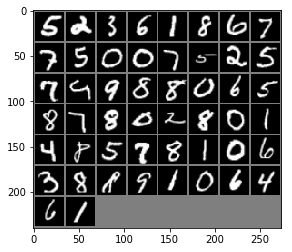

In [58]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [59]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [60]:
trainset[0][0].size()

torch.Size([1, 32, 32])

In [61]:
def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
def gen_weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))
        x = x.squeeze()

        return x


In [62]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())


torch.Size([10, 1, 32, 32])
torch.Size([10])


In [63]:
from bgan.bgan import BGAN

In [64]:
batch_size = 50
z_dim = 100

In [65]:
# prior = UninformativePrior()
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()
# gen.apply(weight_init)
gen.apply(gen_weight_init)
disc.apply(weight_init)
bgan = BGAN(gen, disc, prior, alpha=.9, eta=0.00001, disc_lr = 0.00002, gen_observed=20000, MAP=False, cuda=True)
samples = []

Moving generator and discriminator to GPU


In [66]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))

torch.Size([100, 512, 4, 4]) 18.1199
torch.Size([512]) 0.0
torch.Size([512]) 12.8935
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 29.0011
torch.Size([256]) 0.0
torch.Size([256]) 9.51512
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 14.4863
torch.Size([128]) 0.0
torch.Size([128]) 6.28361
torch.Size([128]) 0.0
torch.Size([128, 1, 4, 4]) 0.920407
torch.Size([1]) 0.0


## Training

In [67]:
num_samples = 10

In [108]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(30):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv.cuda())
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).cpu().data.numpy())
samples = np.vstack(samples)

	 0.00212428 7.71207
0
	 0.00404554 6.4025
1
	 0.00176426 8.10694
2
	 0.000620581 8.82845
3
	 0.00306552 6.58959
4
	 0.00196739 5.69128
5
	 0.00327552 5.72775
6
	 0.00175464 7.14532
7
	 0.00155369 8.20012
8
	 0.00208276 5.88261
9
	 0.00168511 7.28248
10
	 0.00303876 6.80226
11
	 0.00389901 6.57311
12
	 0.0067786 6.64284
13
	 0.00407538 6.01064
14
	 0.000547558 8.18953
15
	 0.00374036 8.1441
16
	 0.00242296 13.9802
17
	 0.00139964 8.02614
18
	 0.000504561 9.00311
19
	 0.00356039 6.37772
20
	 0.00683217 5.45228
21
	 0.00265456 6.89377
22
	 0.000270487 8.63958
23
	 0.0016056 7.52637
24
	 0.0141365 5.68042
25
	 0.00180948 7.0546
26
	 0.0028585 7.91939
27
	 0.00221605 7.64093
28
	 0.00600454 5.68686
29


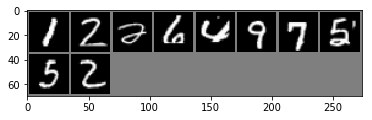

In [109]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [110]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [111]:
# samples = bgan.sample(100).cpu().data.numpy()

In [112]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [113]:
samples_arr.shape

(1100, 1, 32, 32)

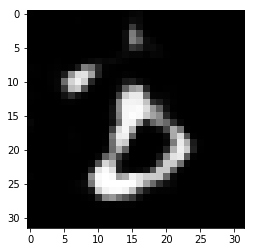

In [114]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [115]:
np.max(batch.numpy())

1.0

In [116]:
samples_arr.shape

(1100, 1, 32, 32)

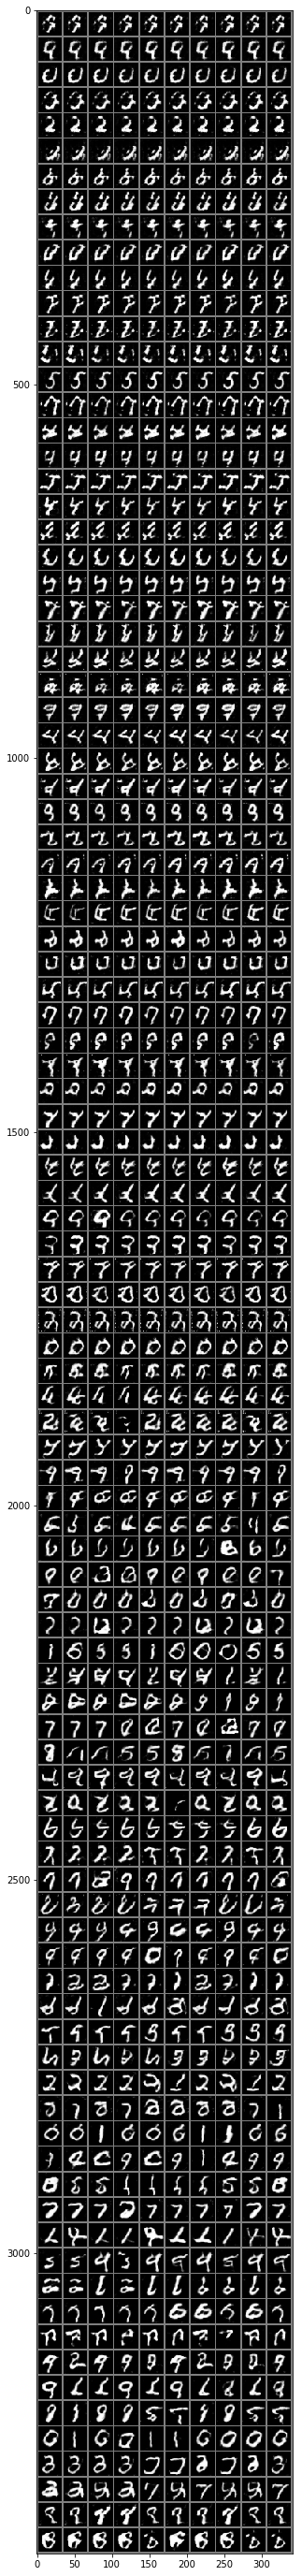

In [117]:
plt.figure(figsize=(20, 50))
show_epochs = [20, 30]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
# imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[-1000:]), nrow=10))


In [231]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())

In [232]:
sample_probs

Variable containing:
1.00000e-20 *
  0.4522
  0.1922
  0.3036
  0.4392
  0.1848
  1.5164
  0.4982
  0.8398
  0.2858
  0.6793
  0.4012
  0.1287
  0.2649
  0.5890
  0.1416
  1.2532
  1.0863
  0.2694
  1.7121
  0.4283
  0.2509
  0.4113
  0.1057
  0.9219
  1.0674
  0.3448
  0.4309
  0.5785
  0.2870
  1.4667
  0.4478
  0.9585
  0.5954
  0.2946
  0.1166
  0.2767
  0.2845
  0.4299
  2.9327
  0.2198
  0.3216
  0.1603
  0.1138
  0.4855
  0.3680
  0.4580
  1.5890
  2.3397
  0.3754
  0.5708
  0.4973
  0.1367
  1.0316
  0.1913
  0.3745
  0.3049
  0.8399
  1.8432
  0.2965
  0.2935
  0.5819
  0.5188
  0.2772
  0.2128
  2.0933
  0.4892
  0.2451
  0.0923
  0.9113
  0.2953
  0.4009
  0.8969
  0.1752
  0.1792
  0.6155
  0.2812
  0.1118
  1.6429
  0.6773
  1.7840
  0.4768
  0.4536
  0.7689
  0.7097
  0.4027
  0.3429
  0.4573
  0.0868
  0.2309
  1.5800
  0.2369
  0.5229
  0.9087
  0.4023
  1.7018
  0.8112
  0.0878
  0.1963
  0.6600
  0.8844
[torch.cuda.FloatTensor of size 100 (GPU 0)]

In [233]:
disc(Variable(batch).cuda())

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 50 (GPU 0)]